This notebook use ARIMA model to forecast wheat export for 75 countries

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For ARIMA model
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

## 1. Data import 

In [83]:
# Read in processed data
wheat_export = pd.read_csv('../data/processed/wheat_export.csv',parse_dates=['year'],
                          index_col='year')  
print('Shape of the dataframe:',wheat_export.shape)
wheat_export.head()

Shape of the dataframe: (32, 75)


,Argentina,Australia,Austria,Barbados,Belarus,Belgium,Brazil,Bulgaria,Canada,Chile,...,Turkey,Uganda,Ukraine,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Yemen,Zambia,Zimbabwe
year,,,,,,,,,,,,,,,,,,,,,
1986-01-01,374614.0,1837595.0,32330.0,1.0,0.0,0.0,0.0,41970.0,2030112.0,10.0,...,1836.0,0.0,0.0,539790.0,0.0,2996911.0,0.0,0.0,0.0,0.0
1987-01-01,351003.0,1369375.0,40372.0,0.0,0.0,0.0,0.0,0.0,2409105.0,2421.0,...,28298.0,0.0,0.0,436869.0,0.0,3024544.0,0.0,0.0,0.0,8.0
1988-01-01,355226.0,1066732.0,78313.0,0.0,0.0,0.0,0.0,63101.0,3596008.0,18.0,...,173522.0,0.0,0.0,246768.0,0.0,4858495.0,0.0,0.0,0.0,0.0
1989-01-01,657540.0,1382707.0,79656.0,0.0,0.0,0.0,0.0,0.0,2173767.0,25.0,...,67682.0,0.0,0.0,462332.0,0.0,5905543.0,24194.0,0.0,0.0,0.0
1990-01-01,870936.0,1664054.0,53462.0,291.0,0.0,0.0,0.0,0.0,2847737.0,356.0,...,4382.0,0.0,0.0,746334.0,0.0,3866314.0,22861.0,0.0,0.0,0.0


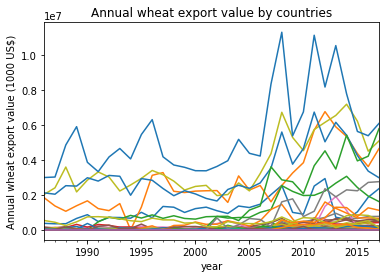

In [85]:
# Visualize data by countries 
wheat_export.plot(legend=False)
plt.title('Annual wheat export value by countries')
plt.ylabel('Annual wheat export value (1000 US$)')
plt.show()

## 1.2 Check stationarity of time series

In [277]:
def stationarity(df):
    '''function to run Dickey-Fuller test on time series for each country,
    return list of countries that did not pass the test, and total number of countries'''
    non_stationary = []
    
    for country in df.columns:
        stationarity = adfuller(df[country].dropna())
        
        if stationarity[1] <= 0.05:
            non_stationary.append((country,stationarity[1]))
    non_stationary = pd.DataFrame(non_stationary, columns=['country','p_value'])
    return non_stationary['country'].tolist(), len(non_stationary)

In [279]:
stationarity(wheat_export)[1] # In original data, 23 countries did not pass the test

23

In [280]:
# Use 3-year rolling means to smooth time series
rolling_countries = pd.DataFrame(index = wheat_export.index) # empty df with same index

for country in wheat_export.columns:
    rolling = wheat_export[country].rolling(3).mean()
    rolling_countries = pd.concat([rolling_countries,rolling],axis=1)

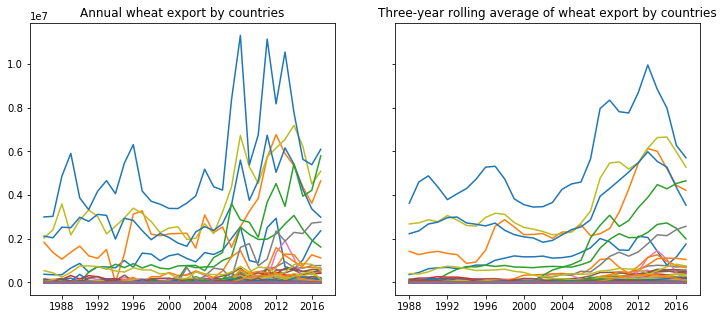

In [272]:
# Visually compare original data and rolling means

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(12,5),sharey=True)
ax1.plot(wheat_export)
ax1.set_title('Annual wheat export by countries')
ax2.plot(rolling_countries)
ax2.set_title('Three-year rolling average of wheat export by countries')
plt.show()


In [283]:
# With 3-year rolling mean, 12 countries did not pass the test
country12 = stationarity(rolling_countries)[0] 
country12

['Brazil',
 'Chile',
 'China, Hong Kong SAR',
 'France',
 'Greece',
 'Latvia',
 'Senegal',
 'Singapore',
 'Trinidad and Tobago',
 'Turkey',
 'Uganda',
 'Yemen']

In [302]:
# Differencing of the 12 non-stationary countries removed 4, resulted in 8 countries still non-stationary
# For simplicity, all 12 countries shall be removed from analysis 
country8 = stationarity(rolling_countries[country12].diff())[0]
country8

['Chile',
 'China, Hong Kong SAR',
 'France',
 'Greece',
 'Latvia',
 'Senegal',
 'Turkey',
 'Yemen']

In [343]:
# Update country list in rolling_countries
wheat_export_countries = wheat_export.columns.tolist()
countries = [i for i in wheat_export_countries if i not in country12]

rolling_countries = rolling_countries[countries]
rolling_countries = rolling_countries['1988':] # remove the first two rows which contain NaNs
rolling_countries.shape

(30, 63)

## 1.3 Build ARIMA model with GridSearch

In [420]:
# ref: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
# Step 1: Evaluate an ARIMA model use MSE 

def eval_arima(data, order):
    '''function to split a time series into train and test set, build an ARIMA model
      use rolling one-at-a-time predictions, and reture mean squared error of the model'''
    
    # split dataset into training and testing
    train_size = int(len(data)*0.66)
    train, test = data[0: train_size], data[train_size:]
    
    # Make one prediction/forecast at a time, put the prediction into predictions list, 
    # then add one data from test set to train set for the next model
    rolling_train = [train_index for train_index in train]
    predictions = []
    for test_index in range(len(test)):
        model = ARIMA(rolling_train, order=order)
        model_fit = model.fit()
        one_prediction = model_fit.forecast()[0]
        predictions.append(one_prediction)
        rolling_train.append(test[test_index])
    mse = mean_squared_error(test, predictions)
    return mse

In [421]:
# Step 2: Grid search for order(p,d,q) of ARIMA model

def gridsearch_arima(data, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = eval_arima(data, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    #print('ARIMA%s MSE=%.2E' %(order, mse)) # print out results for each configuration
                except:
                    continue
    print(data.name, best_cfg, 'MSE=%.2E' %best_score)
    return data.name, best_cfg, best_score
    

In [418]:
p_values = [0, 1, 2, 3, 4, 5, 6]
d_values = [0, 1]
q_values = [0, 1, 2]
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Loop through all 63 countries to make predictions 
results = []
for country in rolling_countries.columns:
    country_result = gridsearch_arima(rolling_countries[country], p_values, d_values, q_values)
    countries.append(country_result[0])
    best_arima.append(country_result[1])
    mse.append(country_result[2])
    results.append(country_result)
results = pd.DataFrame(results, columns=['country','best_arima','mse'])


In [437]:
results.head()
results.to_csv('../data/processed/arima_wheat_exportv.csv')
results = results.sort_values(by='mse')

In [439]:
results.head()

,country,best_arima,mse
11,Cyprus,"(2, 0, 1)",7.232631
8,"China, Taiwan Province of","(3, 0, 0)",27.352628
3,Barbados,"(0, 1, 1)",137.565302
33,Morocco,"(0, 1, 0)",3624.170338
37,Norway,"(0, 1, 0)",6014.530648


In [445]:
results = results.set_index('country')

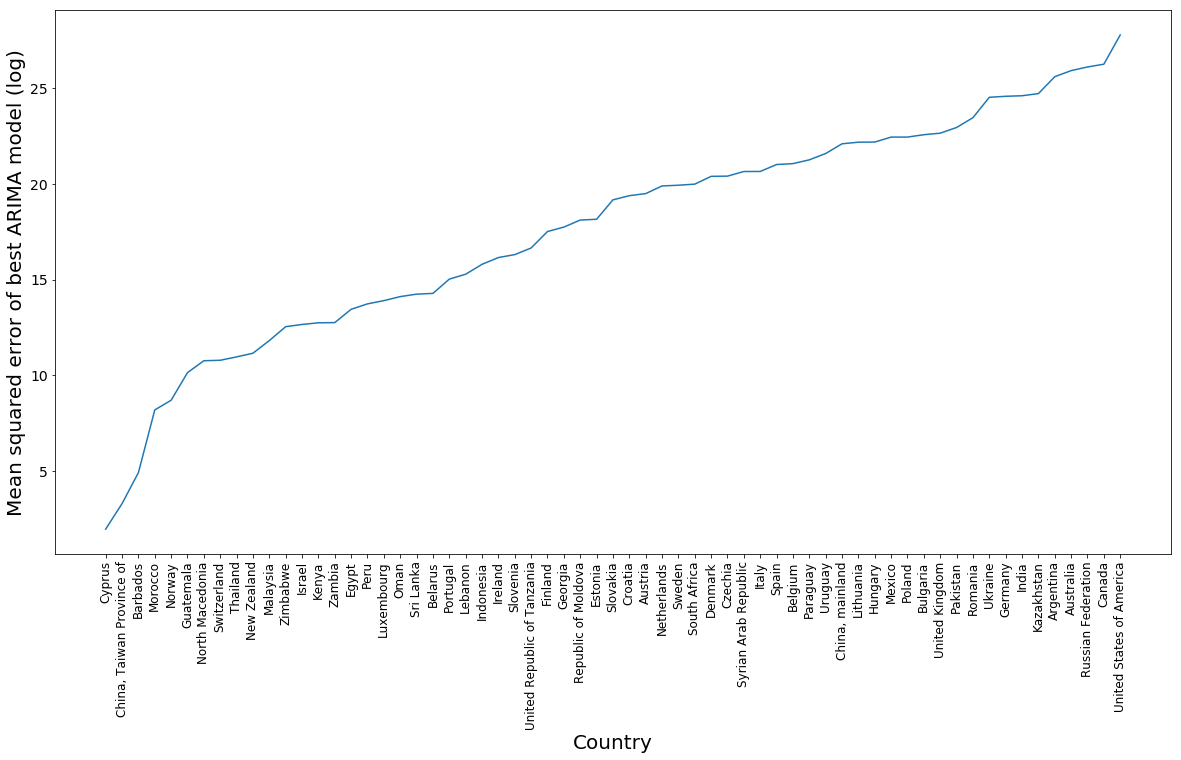

In [453]:
plt.figure(figsize=(20,10))
plt.plot(np.log(results['mse']))
plt.xlabel('Country',fontsize=20)
plt.ylabel('Mean squared error of best ARIMA model (log)',fontsize=20)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=14)
plt.show()

Q: perhaps should scale original export data so ARIMA model performance are comparable across countries? 

### 1.3 Obtain fitted values with best estimates of ARIMA models and forcast into 2025 